# Problem Statement

Santander wants to find which customers will make a specific transaction in the future, irrespective of the amount of money transacted.

#### This kernels consists of : 

* Importing Data
* Reducing Memory Usage
* Missing Values
* Basic EDA
* Feature Correlation
* Baseliner
* Decision Tree
* Model Importances
* Bayesian Optimisation
* ELI5
* 5Fold Submission

In [1]:
!pip install pydotplus

    100% |████████████████████████████████| 286kB 8.7MB/s eta 0:00:01
  Stored in directory: /tmp/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import gc
import os
import time
import math
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold

from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold

# Importing all models

# Classification
from sklearn.linear_model import LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
    RandomForestClassifier, VotingClassifier


import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from catboost import Pool, CatBoostClassifier

import warnings
print(os.listdir("../input"))
warnings.simplefilter('ignore')

['test.csv', 'train.csv', 'sample_submission.csv']


# Importing Data and Reducing Memory

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [4]:
train = import_data("../input/train.csv")
test = import_data("../input/test.csv")
sub = import_data("../input/sample_submission.csv")

print("\n\nTrain Size : \t{}\nTest Size : \t{}".format(train.shape, test.shape))

Memory usage of dataframe is 308.23 MB
Memory usage after optimization is: 83.77 MB
Decreased by 72.8%
Memory usage of dataframe is 306.70 MB
Memory usage after optimization is: 83.58 MB
Decreased by 72.7%
Memory usage of dataframe is 3.05 MB
Memory usage after optimization is: 7.48 MB
Decreased by -145.1%


Train Size : 	(200000, 202)
Test Size : 	(200000, 201)


In [5]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.921875,-6.785156,11.906250,5.093750,11.460938,-9.281250,5.117188,18.625000,-4.921875,5.746094,2.925781,3.181641,14.015625,0.574707,8.796875,14.570312,5.750000,-7.238281,4.285156,30.718750,10.531250,16.218750,2.578125,2.470703,14.382812,13.429688,-5.148438,-0.407227,4.929688,5.996094,-0.308594,12.906250,-3.876953,16.890625,11.195312,10.578125,0.676270,7.886719,...,15.460938,5.312500,3.615234,5.039062,6.675781,12.664062,2.701172,-0.697266,9.601562,5.488281,-4.765625,-8.421875,20.875000,3.152344,18.562500,7.742188,-10.125000,13.726562,-3.519531,1.719727,-8.406250,9.015625,3.066406,14.367188,25.843750,5.875000,11.843750,-19.718750,17.578125,0.585938,4.433594,3.964844,3.136719,1.691406,18.515625,-2.398438,7.878906,8.562500,12.781250,-1.091797
1,train_1,0,11.500000,-4.148438,13.859375,5.390625,12.359375,7.042969,5.621094,16.531250,3.146484,8.085938,-0.403320,8.054688,14.023438,8.414062,5.433594,13.703125,13.828125,-15.585938,7.800781,28.578125,3.427734,2.740234,8.554688,3.371094,6.976562,13.890625,-11.765625,-2.558594,5.046875,0.548340,-9.296875,7.875000,1.286133,19.375000,11.367188,0.739746,2.798828,5.843750,...,29.484375,5.867188,3.820312,15.835938,-5.011719,15.132812,3.201172,9.320312,3.882812,5.800781,5.539062,5.097656,22.031250,5.511719,30.265625,10.500000,-7.234375,16.578125,-7.347656,11.078125,-5.593750,9.484375,-14.906250,9.421875,22.546875,-4.863281,7.656250,-15.929688,13.320312,-0.356689,7.640625,7.722656,2.583984,10.953125,15.429688,2.033203,8.125000,8.789062,18.359375,1.952148
2,train_2,0,8.609375,-2.746094,12.078125,7.894531,10.585938,-9.085938,6.941406,14.617188,-4.917969,5.953125,-0.324951,-11.265625,14.195312,7.312500,7.523438,14.648438,7.679688,-1.739258,4.699219,20.484375,17.750000,18.140625,1.214844,3.513672,5.675781,13.218750,-7.992188,-2.902344,5.847656,6.144531,-11.101562,12.484375,-2.287109,19.046875,11.046875,4.109375,4.699219,6.933594,...,13.203125,5.843750,4.707031,5.714844,-1.041016,20.515625,3.279297,-5.593750,7.316406,5.769531,-7.093750,-3.912109,7.257812,-5.824219,25.687500,10.921875,-0.310303,8.843750,-9.703125,2.400391,-4.292969,9.390625,-13.265625,3.154297,23.093750,-5.300781,5.375000,-6.265625,10.195312,-0.841797,2.906250,9.789062,1.669922,1.685547,21.609375,3.142578,-6.519531,8.265625,14.718750,0.396484
3,train_3,0,11.062500,-2.152344,8.953125,7.195312,12.585938,-1.835938,5.843750,14.921875,-5.859375,8.242188,2.306641,2.810547,13.843750,11.968750,6.457031,14.835938,10.742188,-0.429932,15.945312,13.726562,20.296875,12.554688,6.820312,2.722656,12.132812,13.734375,0.813477,-0.905762,5.906250,2.839844,-15.242188,10.437500,-2.572266,6.179688,10.609375,-5.914062,8.171875,2.851562,...,31.890625,5.968750,7.207031,3.890625,-11.085938,17.250000,2.587891,-2.701172,0.563965,5.343750,-7.152344,-6.191406,18.234375,11.710938,14.750000,8.101562,11.875000,13.953125,-10.468750,5.695312,-3.753906,8.414062,1.898438,7.261719,-0.463867,-0.049805,7.933594,-12.828125,12.414062,1.848633,4.464844,4.742188,0.717773,1.421875,23.031250,-1.270508,-2.927734,10.289062,17.968750,-9.000000
4,train_4,0,9.835938,-1.483398,12.875000,6.636719,12.273438,2.449219,5.941406,19.250000,6.265625,7.679688,-9.445312,-12.140625,13.851562,7.890625,7.789062,15.054688,8.484375,-3.068359,6.527344,11.312500,21.421875,18.953125,10.109375,2.714844,14.210938,13.546875,3.173828,-3.341797,5.902344,7.933594,-3.158203,9.468750,-0.008301,19.328125,12.406250,0.

In [6]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.062500,7.781250,12.953125,9.429688,11.429688,-2.380859,5.847656,18.265625,2.132812,8.812500,-2.025391,-4.355469,13.968750,0.345703,7.539062,14.500000,7.703125,-19.093750,15.578125,16.171875,3.708984,18.812500,1.589844,3.064453,6.449219,14.117188,-9.492188,-2.191406,5.710938,3.787109,-1.797852,9.265625,2.066406,12.773438,11.335938,8.148438,-0.061005,3.533203,9.781250,...,5.921875,5.410156,3.830078,5.738281,-8.609375,22.953125,2.552734,-0.283691,4.339844,5.183594,4.261719,1.677734,29.078125,8.468750,18.125000,12.281250,-0.691406,10.218750,-5.558594,2.292969,-4.535156,10.390625,-15.492188,3.968750,31.359375,-1.165039,9.289062,-23.578125,13.265625,1.659180,-2.156250,11.851562,-1.429688,2.451172,13.710938,2.466797,4.367188,10.718750,15.468750,-8.718750
1,test_1,8.531250,1.253906,11.304688,5.187500,9.195312,-4.011719,6.019531,18.625000,-4.414062,5.972656,-1.380859,-0.331055,14.109375,2.566406,5.500000,14.187500,7.019531,4.656250,29.156250,0.091003,12.148438,3.138672,5.257812,2.421875,16.203125,13.500000,-5.234375,-3.664062,5.707031,2.996094,-10.468750,11.492188,-0.965820,15.343750,10.632812,0.896484,6.742188,2.341797,12.867188,...,30.968750,5.671875,3.687500,13.039062,-10.656250,15.515625,3.218750,9.054688,7.054688,5.390625,-0.771973,-8.179688,29.921875,-5.628906,10.500000,9.609375,-0.493408,8.171875,-4.359375,5.210938,0.408691,12.000000,-10.382812,5.847656,25.203125,-8.843750,11.828125,-8.710938,15.906250,0.980957,10.617188,8.835938,0.940430,10.125000,15.578125,0.477295,-1.485352,9.875000,19.125000,-20.968750
2,test_2,5.484375,-10.359375,10.140625,7.046875,10.265625,9.804688,4.894531,20.250000,1.523438,8.343750,-4.707031,-3.042969,13.671875,3.818359,10.851562,14.210938,9.882812,2.654297,21.218750,20.812500,12.468750,12.367188,4.746094,2.792969,5.218750,13.570312,-15.421875,-0.165527,7.261719,3.431641,-9.148438,9.734375,3.105469,22.312500,11.960938,9.921875,4.070312,4.992188,8.070312,...,39.375000,5.523438,3.316406,4.332031,-0.538086,13.304688,3.125000,-4.171875,1.233398,6.152344,-0.039093,1.495117,16.890625,-2.978516,27.406250,15.882812,-10.968750,15.640625,-9.406250,4.460938,-3.083984,8.554688,-2.851562,13.476562,24.468750,-3.482422,4.917969,-2.072266,11.539062,1.181641,-0.748535,10.992188,1.980469,2.179688,12.984375,2.128906,-7.109375,7.062500,19.890625,-23.171875
3,test_3,8.539062,-1.322266,12.023438,6.574219,8.843750,3.173828,4.941406,20.562500,3.375000,7.457031,0.009499,-5.066406,14.054688,13.500000,8.765625,14.734375,10.039062,-15.351562,2.126953,21.484375,14.539062,12.554688,2.970703,4.238281,13.781250,14.140625,1.005859,-1.347656,5.257812,6.589844,6.214844,9.554688,2.363281,10.210938,10.804688,-2.558594,6.070312,3.261719,16.562500,...,19.718750,5.386719,3.677734,7.476562,-11.078125,24.875000,2.640625,2.267578,7.277344,5.640625,7.203125,3.451172,2.412109,11.164062,14.546875,10.617188,-5.792969,13.937500,7.109375,1.101562,9.460938,9.828125,5.992188,5.164062,8.117188,3.664062,3.310547,-19.781250,13.453125,1.310547,9.570312,9.078125,1.658203,3.582031,15.187500,3.166016,3.957031,9.226562,13.015625,-4.210938
4,test_4,11.703125,-0.132690,14.132812,7.750000,9.101562,-8.585938,6.859375,10.601562,2.988281,7.144531,5.101562,-3.283203,14.101562,8.968750,4.726562,14.578125,11.859375,3.148438,18.015625,13.796875,1.602539,16.312500,6.796875,3.601562,13.656250,13.882812,8.625000,-2.265625,5.226562,7.015625,-15.695312,10.625000,-4.765625,17.546

### All the features are masked. This way I don't think we can create features based on domain knowledge if we don't know what the feature represent.
* But we can make aggregate features like count, max, min, mean, groupby features if we somehow find any relation between any two features. 

# Missing Values
Is the data missing at random? Or is this missing systematically? If the user chooses not to respond to some questions, they will be captured as 'blank' in the system/data.

So there could be 3 reasons for these blanks:

1. systematically skipping questions
1. random skipping questions
1. no opinion about those questions
At any rate, 1 and 2 might be solved by imputing the blanks/NAs, but the third option might not, resulting in a bias (?).

In [7]:
def missing_values(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

miss_train = missing_values(train)
miss_test = missing_values(test)

Your selected dataframe has 202 columns.
There are 0 columns that have missing values.
Your selected dataframe has 201 columns.
There are 0 columns that have missing values.


### Cool we don't have any missing values.

# Basic EDA

In [8]:
def univariate(df, col, vartype, hue=None):
    '''
    Univariate function will plot the graphs based on the parameters.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuos or categorical
                Continuos(0)   : Distribution, Violin & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : It's only applicable for categorical analysis.

    Call: univariate(df=data,col='col',vartype=0)
    '''
    sns.set(style="darkgrid")

    if vartype == 0:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col], ax=ax[0])
        ax[1].set_title("Violin Plot")
        sns.violinplot(data=df, x=col, ax=ax[1], inner="quartile")
        ax[2].set_title("Box Plot")
        sns.boxplot(data=df, x=col, ax=ax[2], orient='v')

    if vartype == 1:
        temp = pd.Series(data=hue)
        print(len(temp.unique()))
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4 * len(temp.unique())
        fig.set_size_inches(width, 7)
        ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, hue=hue)
        if len(temp.unique()) > 0:
            for p in ax.patches:
                if p.get_height() > 0:
                    ax.annotate('{:1.1f}%'.format((p.get_height() * 100) / float(len(loan_data))),
                                (p.get_x() + 0.05, p.get_height() + 20))
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x() + 0.32, p.get_height() + 20))
        del temp
    else:
        exit

    plt.show()

# Target Distribution

0


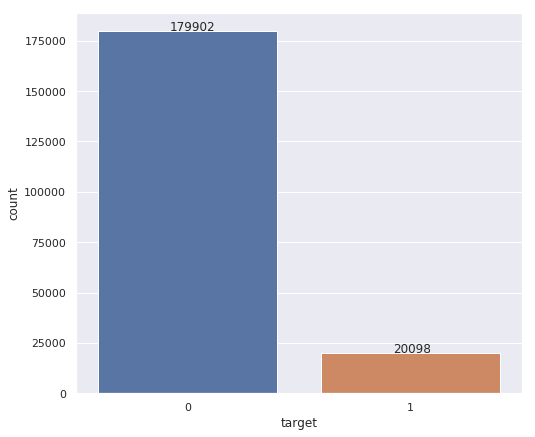

In [9]:
univariate(train, 'target', 1)

In [10]:
train['target'].value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

### Well the data is quite imbalanced. Almost 9:1 ratio of customer not proceding to make a successful transaction.|

# Lets check the masked features
Some measures by which we can do some EDA on masked features are checking their :
* mean
* std
* skew
* kurtosis

In [11]:
target = 'target'
features = train.columns.tolist()
features.remove(target)
features.remove("ID_code")
print("Feature Length : {}".format(len(features)))

Feature Length : 200


# Mean

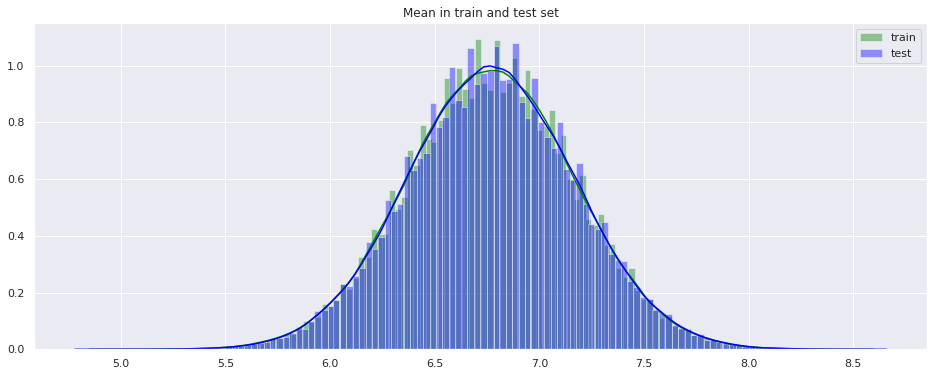

In [12]:
plt.figure(figsize=(16,6))
plt.title("Mean in train and test set")
sns.distplot(train[features].mean(axis=1), color="green", kde=True, bins=120, label='train')
sns.distplot(test[features].mean(axis=1), color="blue", kde=True, bins=120, label='test')
plt.legend()
plt.show()

## Standard Deviation

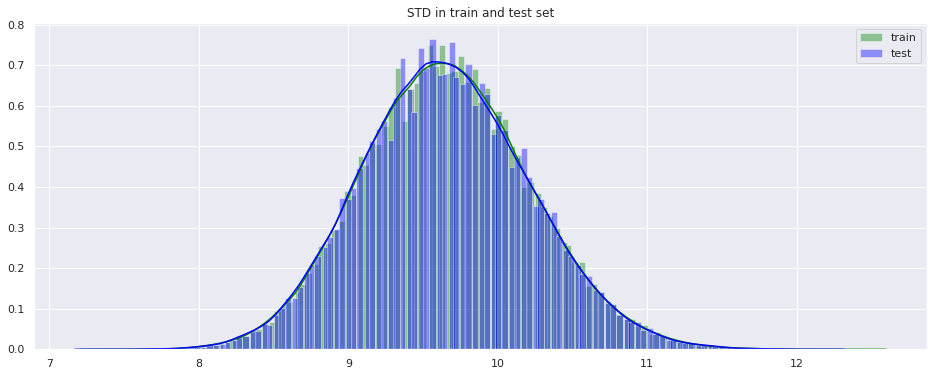

In [13]:
plt.figure(figsize=(16,6))
plt.title("STD in train and test set")
sns.distplot(train[features].std(axis=1), color="green", kde=True, bins=120, label='train')
sns.distplot(test[features].std(axis=1), color="blue", kde=True, bins=120, label='test')
plt.legend()
plt.show()

## Skewness

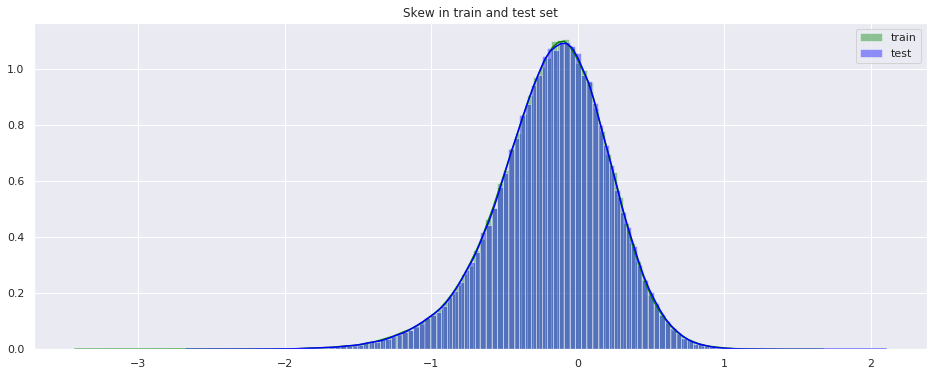

In [14]:
plt.figure(figsize=(16,6))
plt.title("Skew in train and test set")
sns.distplot(train[features].skew(axis=1), color="green", kde=True, bins=120, label='train')
sns.distplot(test[features].skew(axis=1), color="blue", kde=True, bins=120, label='test')
plt.legend()
plt.show()

In [15]:
# Skewness and Kurtosis
print("Skewness: %f" % train['target'].skew())
print("Kurtosis: %f" % train['target'].kurt())

Skewness: 2.657642
Kurtosis: 5.063112


## Kurtosis
As we have most scores of features near mean i.e(located new mean/normally distributed) and kurtosis is 5.063 therefore this is leptokurtic.

# Comparing Distributions of Features

In [16]:
def plot_and_compare(data, num):
    print('Distributions of first {} columns'.format(num))
    plt.figure(figsize=(26, 24))
    for i, col in enumerate(list(data.columns)[2:num + 2]):
        plt.subplot(math.ceil(num/4), 4, i + 1)
        plt.hist(data[col])
        plt.title(col)
    plt.show()

Distributions of first 10 columns


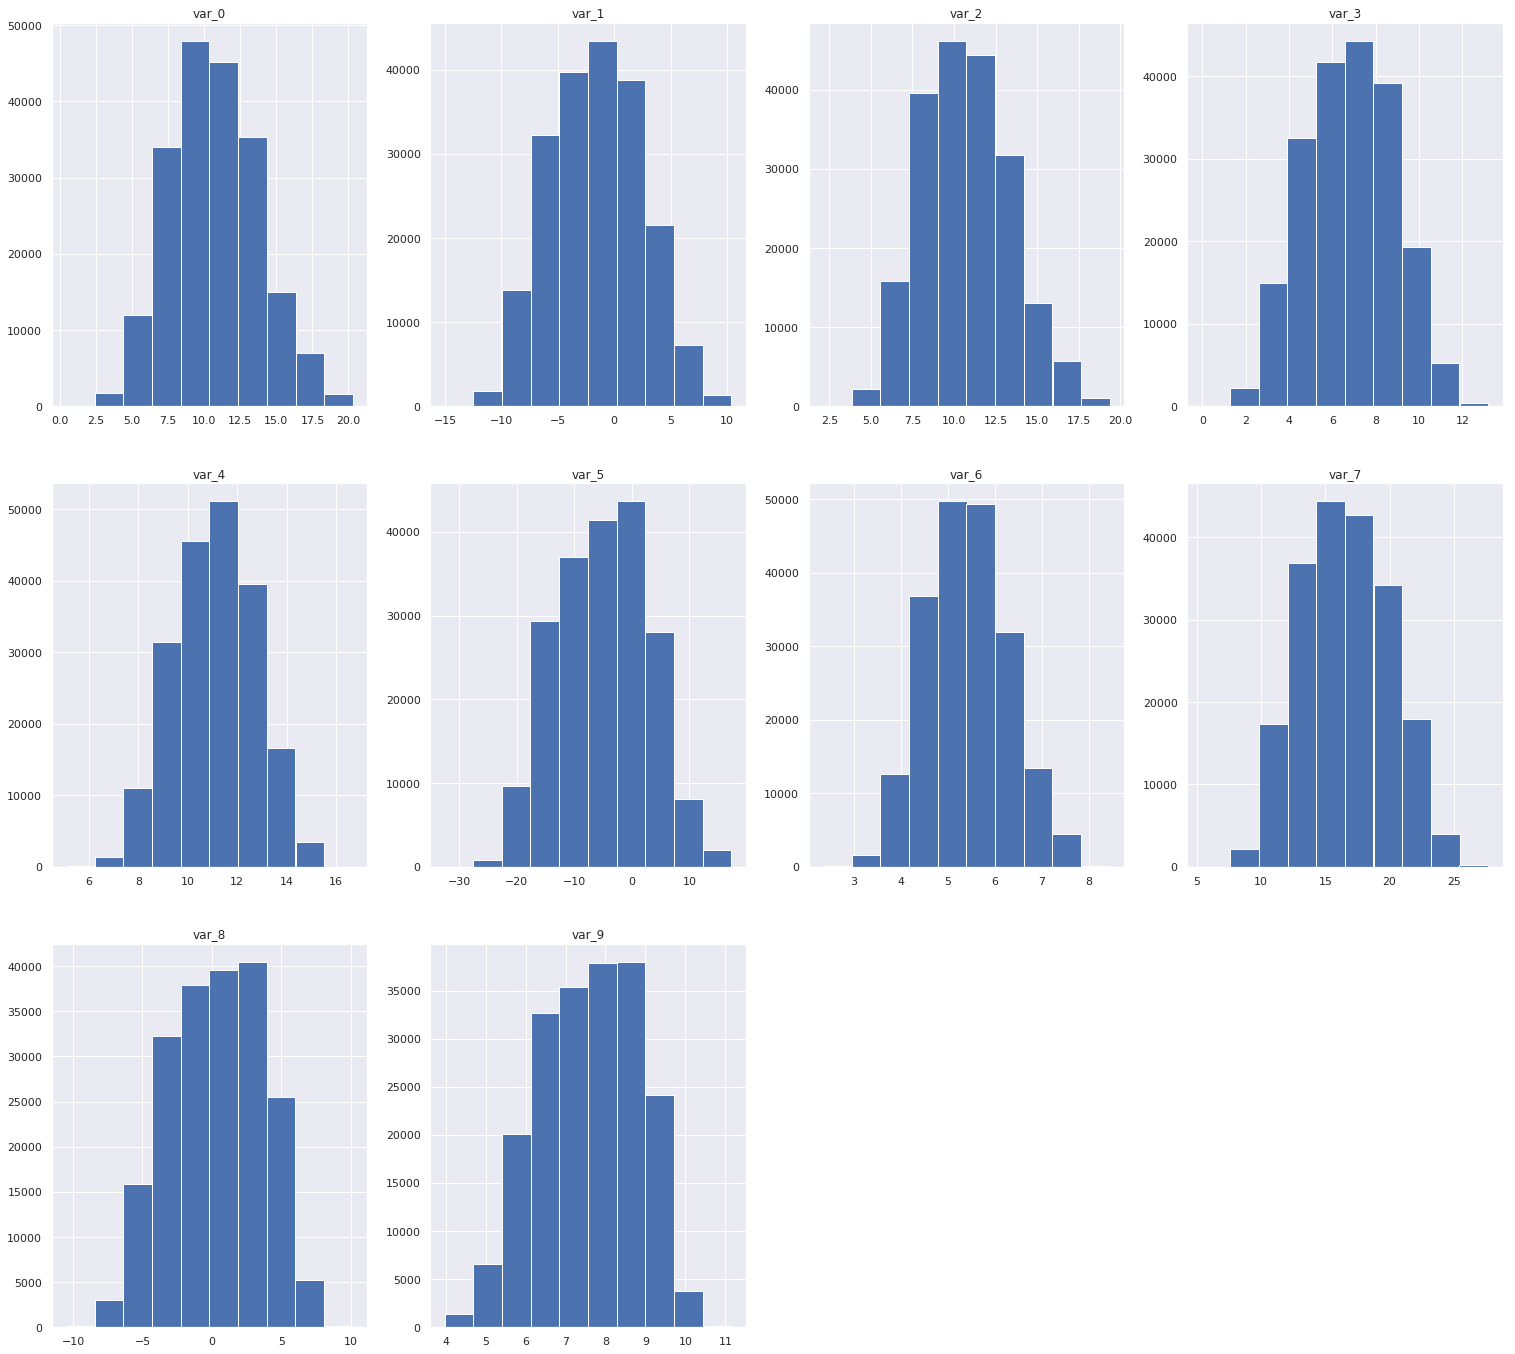

In [17]:
plot_and_compare(train, 10)

### We can see that first 10 features have almost Normal Distribution. Lets check for more(50).

Distributions of first 50 columns


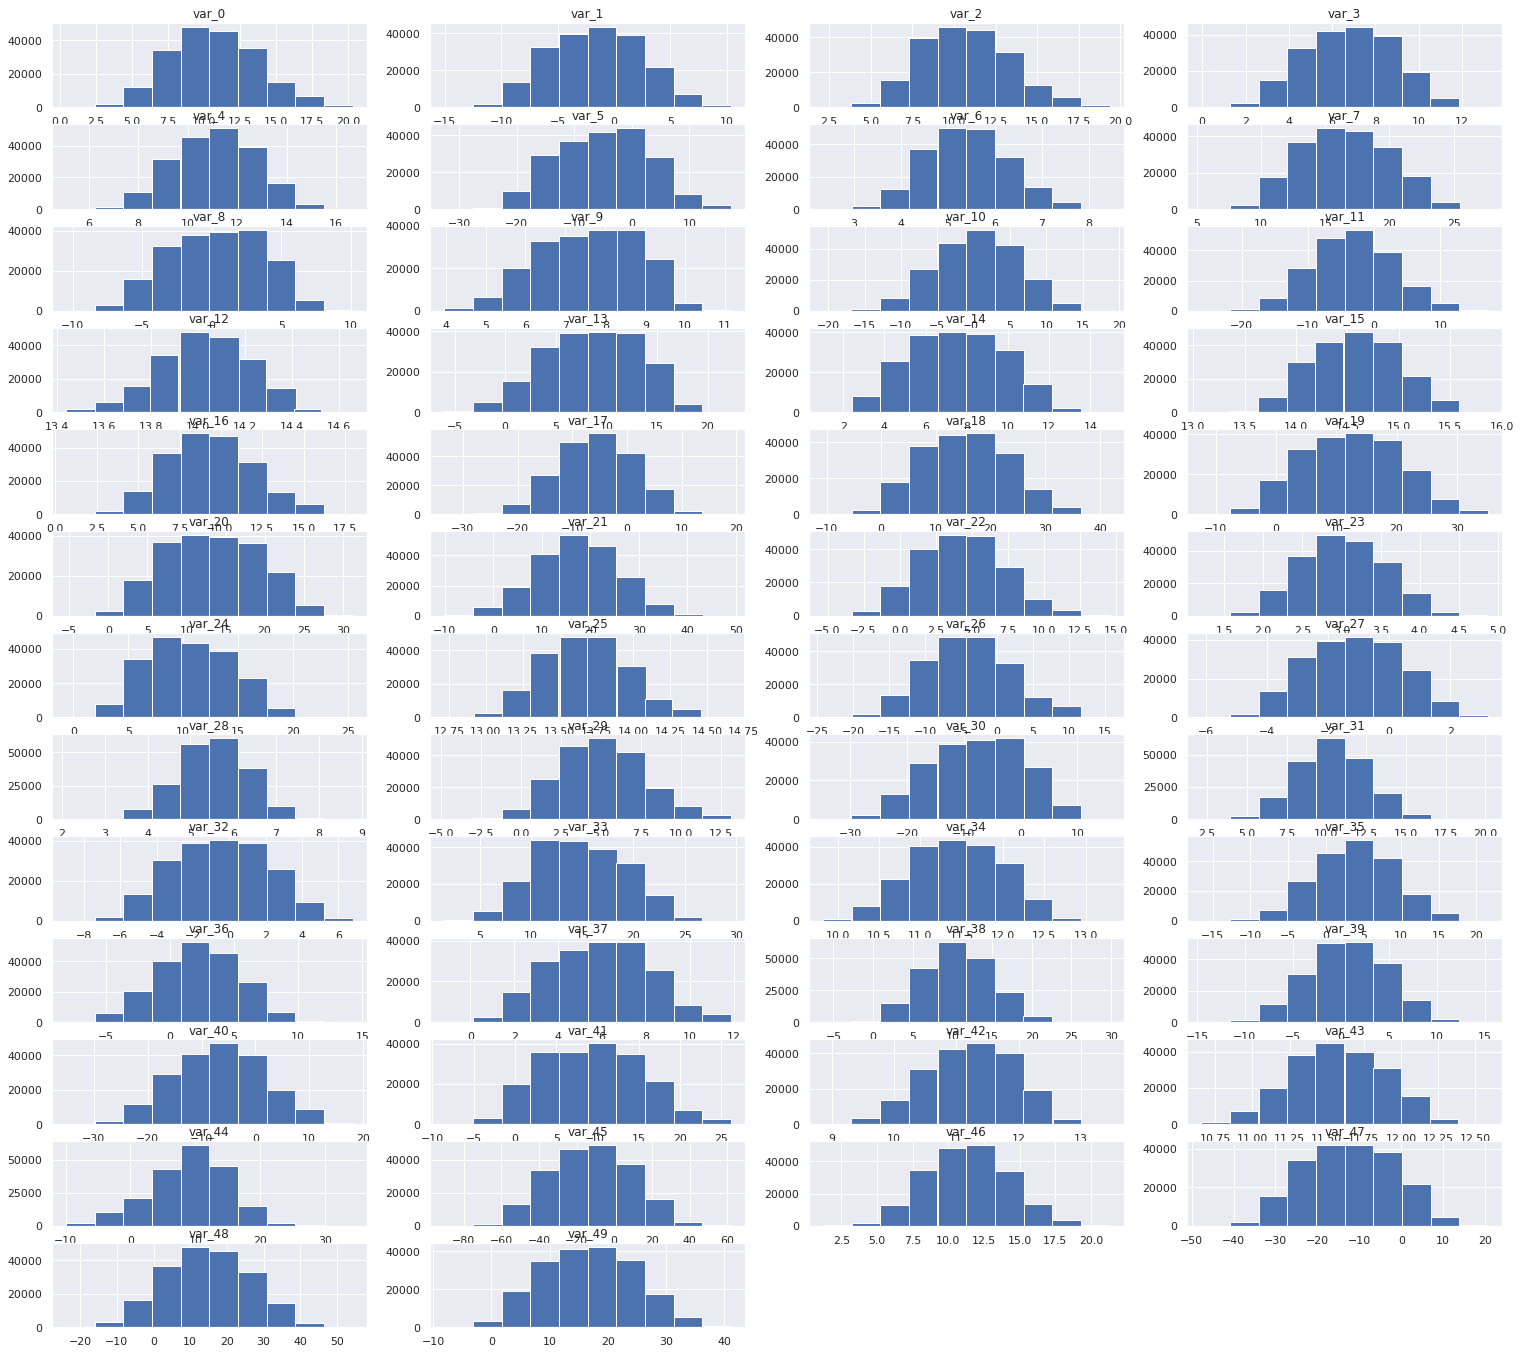

In [18]:
plot_and_compare(train, 50)

### Not only they are normally distributed almost all the features have almost same distribution with same scales. 
### Lets check correlation to confirm the same.

# Correlation

In [19]:
def plot_corr(data):
    data_correlation = data.corr()
    f, ax = plt.subplots(figsize=(25, 25))
    sns.heatmap(data_correlation,
                xticklabels=data_correlation.columns.values,
                yticklabels=data_correlation.columns.values, annot=True)
    plt.show()

In [20]:
# AWFUL lot of time taken as the data is of 200 variables consisting of 0.2 Million recordss
# plot_corr(train.iloc[:10])

### Number of Unique Variables

In [21]:
tuniq = train.nunique().sort_values().reset_index()
tuniq.head()

,index,0
0,target,2
1,var_68,15
2,var_108,127
3,var_12,150
4,var_25,237


# Train and Test Distributions

Do both Train and Test set have same distributions? 

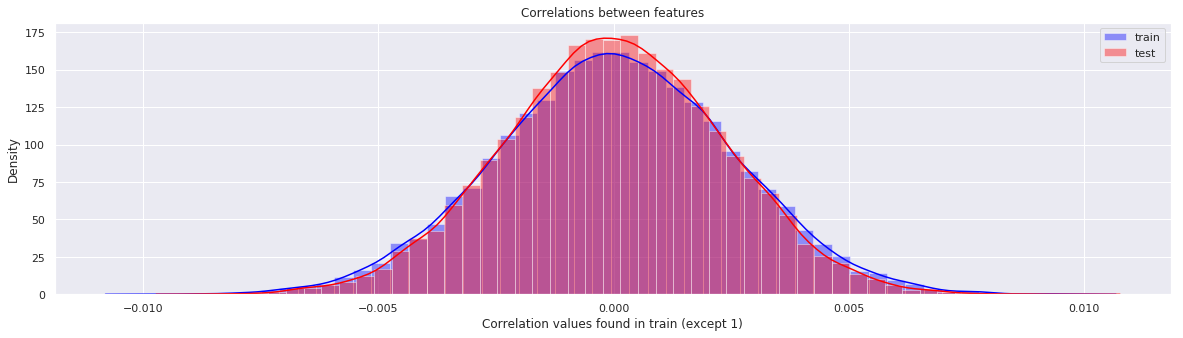

In [22]:
train_correlations = train.drop(["target"], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Red", label="test")
plt.xlabel("Correlation values found in train (except 1)")
plt.ylabel("Density")
plt.title("Correlations between features"); 
plt.legend()

### As we have the peak at 0.0 this states that we have no correlation between features at all. (Might have to check that)

# Modelling
## Baseliner

In [23]:
def baseliner_clas(train, feat, target, cv, metric):

    eval_dict = {}
    models = [lgb.LGBMClassifier()]
    # LogisticRegression(), SVC(), GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(), ExtraTreeClassifier(), AdaBoostClassifier(), BaggingClassifier(),
    # RandomForestClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier(), xgb.XGBClassifier(), cat.CatBoostClassifier(verbose=0)

    for model in models:
        model_name = str(model).split("(")[0]
        results = cross_val_score(model, train[feat], train[target], cv=cv,
                                  scoring=metric)
        print(model_name, results.mean(), results)
        eval_dict[model_name] = results.mean()

    return eval_dict

In [24]:
base_1 = baseliner_clas(train, features, target, 3, 'roc_auc')

LGBMClassifier 0.863698056662805 [0.86160664 0.86346855 0.86601898]


In [25]:
def lgb_model(train, feat, target):
    x_train, x_valid, y_train, y_valid = train_test_split(train[feat], train[target], test_size=0.2, random_state=13)

    train_set = lgb.Dataset(x_train, label=y_train)
    valid_set = lgb.Dataset(x_valid, label=y_valid)

    MAX_ROUNDS = 2000
    params = {
        "boosting": 'gbdt', # "dart",
        "learning_rate": 0.01,
        "nthread": -1,
        "seed": 13,
        "num_boost_round": MAX_ROUNDS,
        "objective": "binary",
        "metric": "auc",
    }

    model = lgb.train(
        params,
        train_set=train_set,
        valid_sets=[train_set, valid_set],
        early_stopping_rounds=50,
        verbose_eval=100
    )

    lgb.plot_importance(model, figsize=(24, 50))

    return model

# LGB Feature Importance 

Training until validation scores don't improve for 50 rounds.
[100]	training's auc: 0.808229	valid_1's auc: 0.783972
[200]	training's auc: 0.849473	valid_1's auc: 0.816763
[300]	training's auc: 0.872012	valid_1's auc: 0.833576
[400]	training's auc: 0.887753	valid_1's auc: 0.845329
[500]	training's auc: 0.899421	valid_1's auc: 0.85369
[600]	training's auc: 0.908498	valid_1's auc: 0.860118
[700]	training's auc: 0.916037	valid_1's auc: 0.865098
[800]	training's auc: 0.922215	valid_1's auc: 0.869045
[900]	training's auc: 0.927419	valid_1's auc: 0.872287
[1000]	training's auc: 0.932136	valid_1's auc: 0.87518
[1100]	training's auc: 0.936347	valid_1's auc: 0.877597
[1200]	training's auc: 0.940073	valid_1's auc: 0.879591
[1300]	training's auc: 0.943386	valid_1's auc: 0.881509
[1400]	training's auc: 0.946381	valid_1's auc: 0.883191
[1500]	training's auc: 0.949136	valid_1's auc: 0.884555
[1600]	training's auc: 0.951636	valid_1's auc: 0.885831
[1700]	training's auc: 0.954023	valid_1's auc: 0.8870

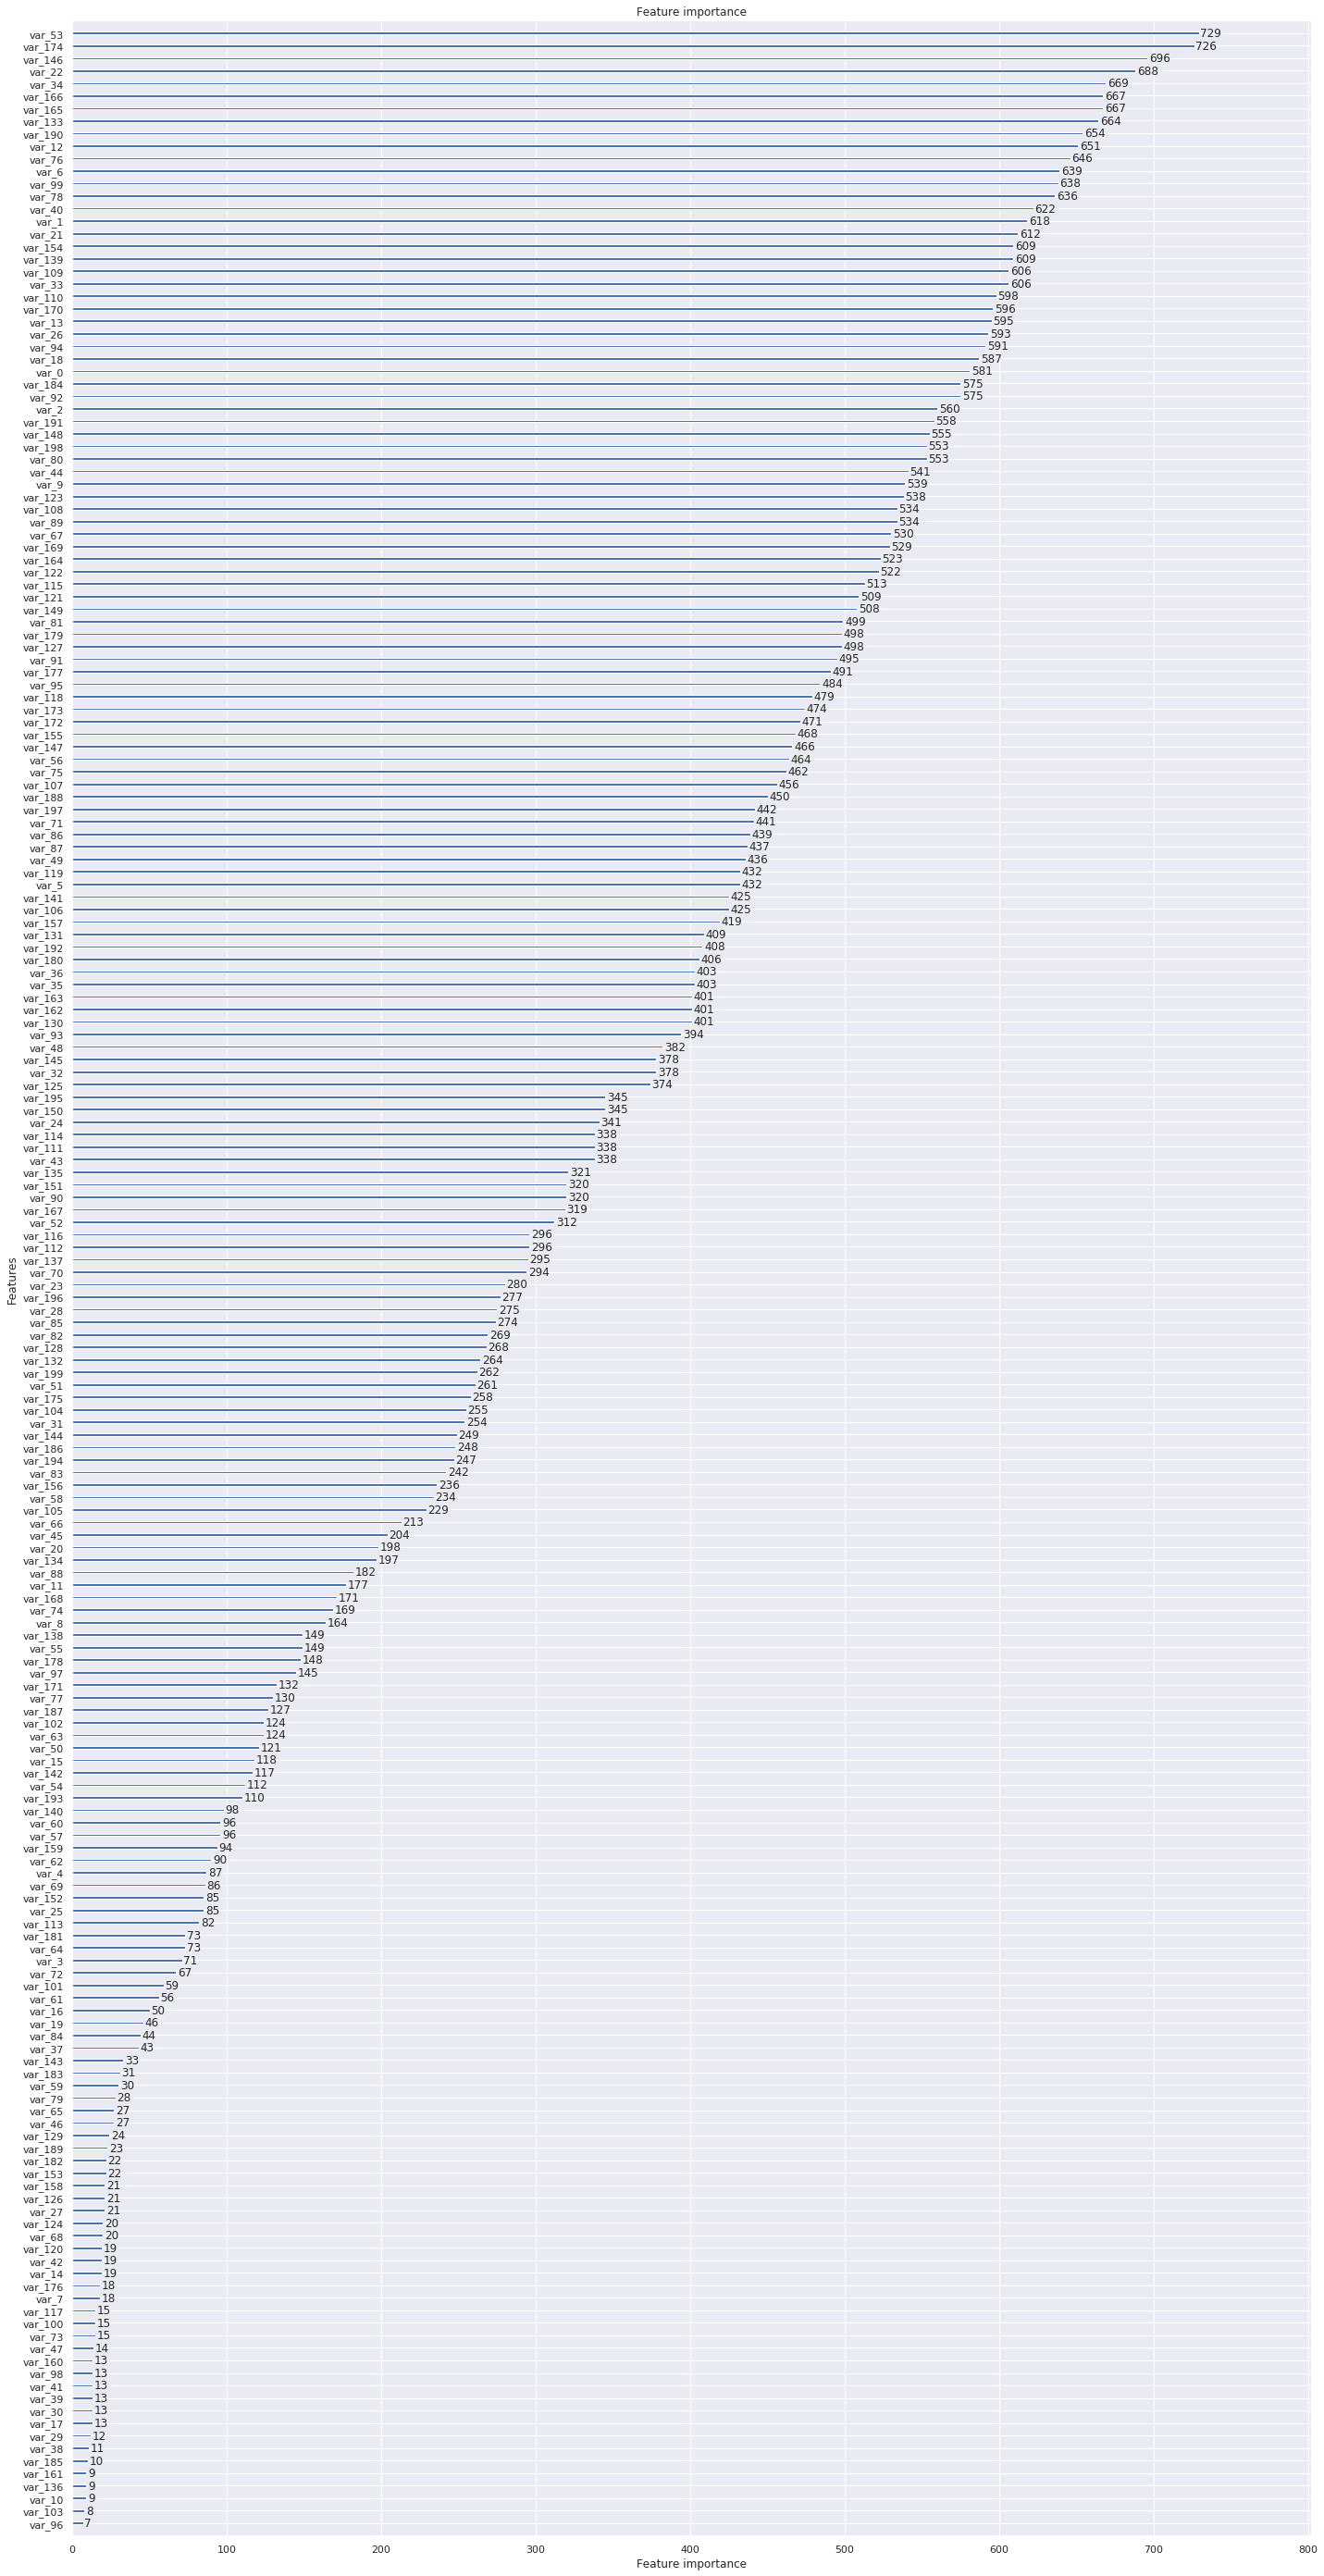

In [26]:
model = lgb_model(train, features, target)

# Decision Tree

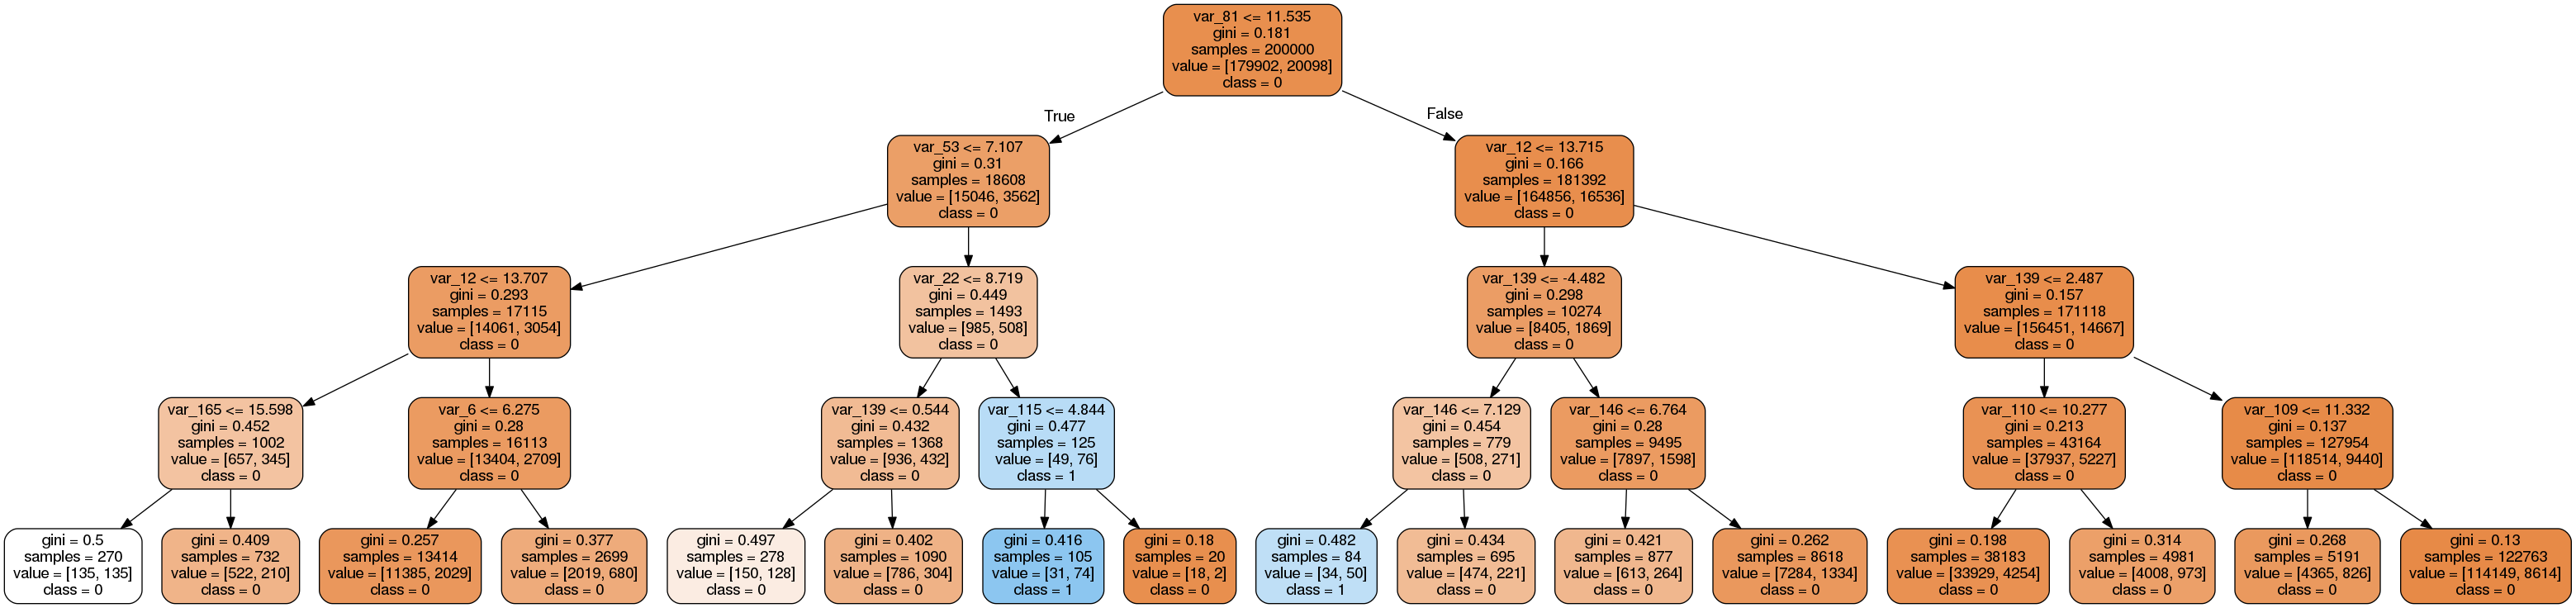

In [27]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image as PImage
from sklearn.externals.six import StringIO

dtree = DecisionTreeClassifier(max_depth=4)
dtree.fit(train[features], train[target])

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data, max_depth = 4, 
                     impurity = True, feature_names = features, 
                     class_names = ['0', '1'], rounded = True, filled= True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
PImage(graph.create_png())

# Bayesian Optimisation

In [28]:
bayesian_tr_index, bayesian_val_index  = list(StratifiedKFold(n_splits=2, shuffle=True, random_state=1).split(train, train.target.values))[0]
print(len(bayesian_tr_index), len(bayesian_val_index))

100000 100000


In [29]:
# Function for LGB model creation for bayesian optimisation

def LGB_bayesian(
    num_leaves,  # int
    min_data_in_leaf,  # int
    learning_rate,
    min_sum_hessian_in_leaf,    # int  
    feature_fraction,
    lambda_l1,
    lambda_l2,
    min_gain_to_split,
    max_depth):
    
    # LightGBM expects next three parameters need to be integer. So we make them integer
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int

    param = {
        'num_leaves': num_leaves,
        'max_bin': 63,
        'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,
        'max_depth': max_depth,
        'save_binary': True, 
        'seed': 13,
        'feature_fraction_seed': 13,
        'bagging_seed': 13,
        'drop_seed': 13,
        'data_random_seed': 13,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,   

    }    
    
    
    xg_train = lgb.Dataset(train.iloc[bayesian_tr_index][features].values,
                           label=train.iloc[bayesian_tr_index][target].values,
                           feature_name=features,
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(train.iloc[bayesian_val_index][features].values,
                           label=train.iloc[bayesian_val_index][target].values,
                           feature_name=features,
                           free_raw_data = False
                           )   

    num_round = 5000
    clf = lgb.train(param, xg_train, num_round, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    
    predictions = clf.predict(train.iloc[bayesian_val_index][features].values, num_iteration=clf.best_iteration)   
    
    score = roc_auc_score(train.iloc[bayesian_val_index][target].values, predictions)
    
    return score

# Region Space for Bayesian Optimisation
region_space_LGB = {
    'num_leaves': (5, 20), 
    'min_data_in_leaf': (5, 20),  
    'learning_rate': (0.01, 0.3),
    'min_sum_hessian_in_leaf': (0.00001, 0.01),    
    'feature_fraction': (0.05, 0.5),
    'lambda_l1': (0, 5.0), 
    'lambda_l2': (0, 5.0), 
    'min_gain_to_split': (0, 1.0),
    'max_depth':(3,15),
}

LGB_BO = BayesianOptimization(LGB_bayesian, region_space_LGB, random_state=13)

In [30]:
init_points = 5
n_iter = 5

LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[172]	valid_0's auc: 0.878482
|  1        |  0.8785   |  0.4      |  1.188    |  4.121    |  0.2901   |  14.67    |  11.8     |  0.609    |  0.007758 |  14.62    |
Training until validation scores don't improve for 50 rounds.
[250]	valid_0's auc: 0.841747
[500]	valid_0's auc: 0.865883
[750]	valid_0's auc: 0.876802
[1000]	valid_0's auc: 0.88262
[1250]	valid_0's auc: 0.886424
[1500]	valid_0's auc: 0.888831
[1750]	valid_0's auc: 0.890229
[2000]	valid_0's auc: 0.890931
[2250]	valid_0's auc: 0.891364
Early stopping, best iteration is:
[2297]	valid_0's auc: 0.891447
|  2        |  0.8914   |  0.3749   |  0.1752   |  1.492    |  0.026

In [31]:
LGB_BO.max['target']

0.893483494395378

In [32]:
LGB_BO.max['params']

{'feature_fraction': 0.0725311213806508,
 'lambda_l1': 4.778909939998174,
 'lambda_l2': 3.220122059503974,
 'learning_rate': 0.07663544326133201,
 'max_depth': 14.99504485809263,
 'min_data_in_leaf': 6.071757005556453,
 'min_gain_to_split': 0.4634735801572327,
 'min_sum_hessian_in_leaf': 0.007510919138894667,
 'num_leaves': 5.001626877554514}

In [33]:
param_lgb = {
        'num_leaves': int(LGB_BO.max['params']['num_leaves']),
        'max_bin': 63,
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']),
        'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'],
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'lambda_l1': LGB_BO.max['params']['lambda_l1'],
        'lambda_l2': LGB_BO.max['params']['lambda_l2'],
        'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'],
        'max_depth': int(LGB_BO.max['params']['max_depth']),
        'save_binary': True,
        'seed': 13,
        'feature_fraction_seed': 13,
        'bagging_seed': 13,
        'drop_seed': 13,
        'data_random_seed': 13,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
    }

# Model Interpreting
### ELI5

In [34]:
import eli5

model = lgb.LGBMClassifier(**param_lgb, n_estimators = 20000, n_jobs = -1)
X_train, X_valid, y_train, y_valid = train_test_split(train[features], train[target], test_size=0.2, stratify=train[target])
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

eli5.show_weights(model, targets=[0, 1], feature_names=list(X_train.columns), top=40, feature_filter=lambda x: x != '<BIAS>')

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.915152	valid_1's auc: 0.891456
[2000]	training's auc: 0.929421	valid_1's auc: 0.895934
Early stopping, best iteration is:
[2356]	training's auc: 0.93366	valid_1's auc: 0.896235


Weight,Feature
0.0285,var_81
0.0245,var_139
0.0208,var_12
0.0208,var_53
0.0192,var_110
0.0165,var_26
0.0164,var_174
0.0161,var_76
0.0161,var_6
0.0158,var_166


#### Taking top 100 features and checking if the scores improves.

In [35]:
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:100]
X1 = train[top_features]
X_train, X_valid, y_train, y_valid = train_test_split(X1, train[target], test_size=0.2, stratify=train[target])
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.904977	valid_1's auc: 0.88435
Early stopping, best iteration is:
[1659]	training's auc: 0.912177	valid_1's auc: 0.88535


LGBMClassifier(bagging_fraction=1.0, bagging_freq=5, bagging_seed=13,
        boost_from_average=False, boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, data_random_seed=13, drop_seed=13,
        feature_fraction=0.0725311213806508, feature_fraction_seed=13,
        importance_type='split', is_unbalance=True,
        lambda_l1=4.778909939998174, lambda_l2=3.220122059503974,
        learning_rate=0.07663544326133201, max_bin=63, max_depth=14,
        metric='auc', min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=6, min_gain_to_split=0.4634735801572327,
        min_split_gain=0.0, min_sum_hessian_in_leaf=0.007510919138894667,
        n_estimators=20000, n_jobs=-1, num_leaves=5, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, save_binary=True,
        seed=13, silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0, verbose=1)

* Without removal score : 0.89538
* With removal score : 0.883403

**So ELI5 isn't helping in reducing the features.**

# 5Fold Prediction & Submission

In [36]:
%%time
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

y_pred_lgb = np.zeros(len(test))
num_round = 20000
for fold_n, (train_index, valid_index) in enumerate(folds.split(train[features], train[target])):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train[features].iloc[train_index], train[features].iloc[valid_index]
    y_train, y_valid = train[target].iloc[train_index], train[target].iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(
        param_lgb,
        train_data,num_round,
        valid_sets = [train_data, valid_data],
        verbose_eval=1000,
        early_stopping_rounds = 1000)
            
    y_pred_lgb += lgb_model.predict(test[features], num_iteration=lgb_model.best_iteration)/5

Fold 0 started at Thu May 23 21:53:56 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.915072	valid_1's auc: 0.8925
[2000]	training's auc: 0.929153	valid_1's auc: 0.89617
[3000]	training's auc: 0.940718	valid_1's auc: 0.896497
[4000]	training's auc: 0.950536	valid_1's auc: 0.896168
Early stopping, best iteration is:
[3245]	training's auc: 0.943273	valid_1's auc: 0.896583
Fold 1 started at Thu May 23 21:55:43 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.915683	valid_1's auc: 0.887972
[2000]	training's auc: 0.929641	valid_1's auc: 0.892794
[3000]	training's auc: 0.941147	valid_1's auc: 0.892949
Early stopping, best iteration is:
[2920]	training's auc: 0.940291	valid_1's auc: 0.893084
Fold 2 started at Thu May 23 21:57:21 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.914678	valid_1's auc: 0.892208
[2000]	training's auc: 0.929145	valid_1's auc: 0.896

In [37]:
# Submitting the 5Fold LGB Predictions
submission_lgb = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_lgb
    })
submission_lgb.to_csv('sub_lgb.csv', index=False)

# This submission score 0.90038 on public leaderboard. (Almost top 9% in Public LB)

# Conclusion

TODO - 
1. H20 AutoML
1. Using XGBoost, Catboost
1. Ensembling, Stacking, Blending
1. Feature Removal